In [1]:
mzml_file_path = '/Users/simon/clms_data/collision_energy_comparison/new.mzML'
box_file_path = '/Users/simon/clms_data/collision_energy_comparison/new_box.csv'

In [2]:
import sys
import os
import pylab as plt
%matplotlib inline
# path to pymzm repo
sys.path.append('/Users/simon/git/pymzm')

In [3]:
from ms2_matching import MZMLFile,load_picked_boxes,map_boxes_to_scans

In [4]:
mzml_file_obj = MZMLFile(mzml_file_path)

boxes = load_picked_boxes(box_file_path)

Loaded 7422 scans


In [5]:
s2b,b2s = map_boxes_to_scans(mzml_file_obj,boxes,half_isolation_window = 0.5)

In [6]:
# find the particular one of interest

In [26]:
for s,bs in s2b.items():
    if 60.0*s.rt_in_minutes < 500:
        continue
    if len(bs) > 2:
        break

In [27]:
# found three interesting boxes

In [28]:
interesting_boxes = bs
for box in bs:
    print(box.mz,box.rt_in_seconds)

234.09718322753906 533.3046173119998
234.13352966308594 493.8051055849998
234.0769805908203 516.650828817


<img src="example.png">

In [38]:
# grab all the MS2 scans
relevant_scans = set()
for box in bs:
    scs = b2s[box]
    for s in scs:
        relevant_scans.add(s)
relevant_scans = list(relevant_scans)
for i,scan in enumerate(relevant_scans):
    print(i,"MZ: {}, RT: {}".format(scan.precursor_mz,scan.rt_in_seconds))

0 MZ: 234.0971221923828, RT: 529.2758848810003
1 MZ: 234.0769805908203, RT: 497.72272894399975
2 MZ: 234.13348388671875, RT: 485.44353408100017
3 MZ: 234.09707641601562, RT: 512.412206961
4 MZ: 234.09722900390625, RT: 546.4852817599999
5 MZ: 234.07691955566406, RT: 479.58586164900004
6 MZ: 234.07701110839844, RT: 515.4949895530002
7 MZ: 234.09719848632812, RT: 495.72568099200004
8 MZ: 234.13357543945312, RT: 501.873211089


In [47]:
sys.path.append('/Users/simon/git/mass-spec-utils/')
from spectrum import SpectralRecord
scan2spectrum = {}
for scan in relevant_scans:
    new_spectrum = SpectralRecord(scan.precursor_mz,scan.peaks,{},scan.source_file,scan.scan_no)
    scan2spectrum[scan] = new_spectrum

In [48]:
from spectral_scoring_functions import cosine_similarity

In [55]:
import numpy as np
sim_mat = np.zeros((len(relevant_scans),len(relevant_scans)))
for i,scan in enumerate(relevant_scans):
    for j,scan2 in enumerate(relevant_scans):
        a,b = cosine_similarity(scan2spectrum[scan],scan2spectrum[scan2],0.2,0)
        sim_mat[i,j] = a

In [60]:
[r,c] = np.where(sim_mat == sim_mat.min())
print(r,c)
sim_mat.min()

[4 5] [5 4]


0.5067111589119851

Following image shows the cosine similarities between all pairs of these spectra. Numbering is as in the figure. Note that spectrum 4 is not in the plot (it's missing to the RHS).

The lowest similarity is 0.507, which is between spectra 4 and 5. Makes sense: 5 is far left centered on 234.077, and 4 is far right, on a different peak, when 234.077 has disappeared.

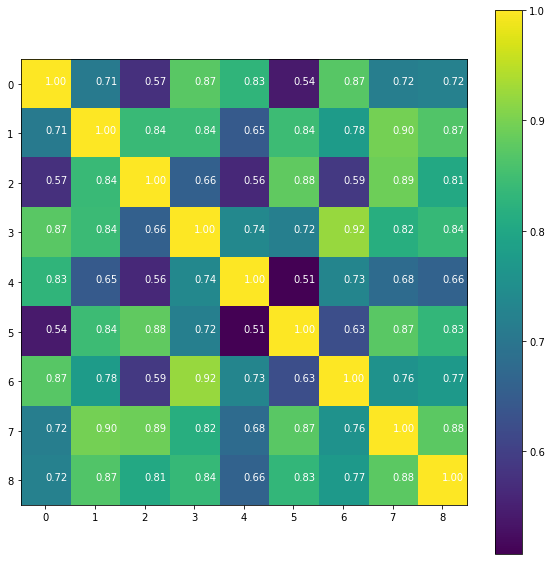

In [234]:
import pylab as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(sim_mat)
plt.colorbar()
ax = plt.gca()
for i in range(len(sim_mat)):
    for j in range(len(sim_mat)):
        ax.text(i,j,"{:.2f}".format(sim_mat[i,j]),color=[1,1,1])

In [83]:
def mirror_plot(spec1,spec2,normalised_peaks = True,**kwargs):
    plt.figure(**kwargs)
    if normalised_peaks:
        peaks1 = spec1.normalised_peaks
        peaks2 = spec2.normalised_peaks
    else:
        peaks1 = spec1.peaks
        pesk12 = spec2.peaks
    for mz,intensity in peaks1:
        plt.plot([mz,mz],[0,intensity],'r')
    for mz,intensity in peaks2:
        plt.plot([mz,mz],[0,-intensity],'b')

Now a specific example spectrum pair, in this case 3 and 6 

Similarity is 0.92


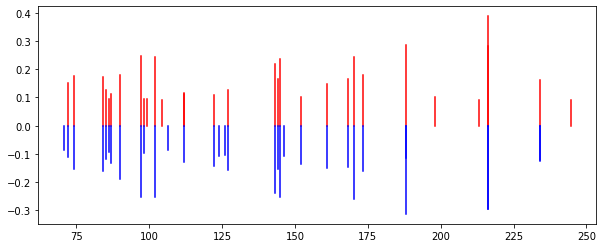

In [84]:
mirror_plot(scan2spectrum[relevant_scans[3]],
           scan2spectrum[relevant_scans[6]],figsize=(10,4))
print("Similarity is {:.2f}".format(sim_mat[6][3]))

And 1 and 7

Similarity is 0.90


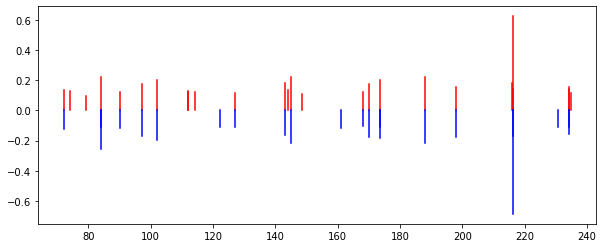

In [85]:
mirror_plot(scan2spectrum[relevant_scans[1]],
           scan2spectrum[relevant_scans[7]],figsize=(10,4))
print("Similarity is {:.2f}".format(sim_mat[1][7]))

And e.g. 3 and 7. These are the same peak!

Similarity is 0.82


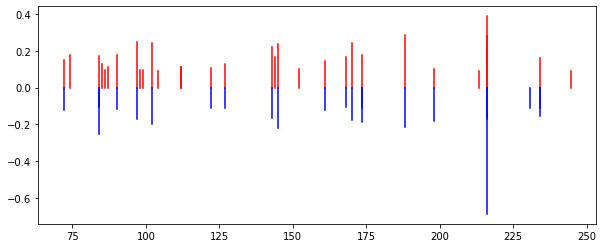

In [86]:
mirror_plot(scan2spectrum[relevant_scans[3]],
           scan2spectrum[relevant_scans[7]],figsize=(10,4))
print("Similarity is {:.2f}".format(sim_mat[3][7]))

To be able to deconvolve, we need the MS1 intensities of each of the peaks at the point where the fragmentations occur.

The following code makes two matrices needed for deconvolution:

1. A matrix of MS1 intensity versus scan - $A$
2. A matrix of MS2 intensity versus scan - $B$

assume that:

- $A$ has one row per MS2 scan and one column per MS1 peak
- $B$ has one row per MS2 scan and one column per unique MS2 m/z

Now, we assume that:

$B = A \times C$

where $C$ has one row per MS1 peak and one column per unique MS2 m/z. I.e. it is the actual MS2 spectra that we want.

So, with $A$ and $B$, we can try and infer $C$.

Can't find peak within 10 ppm, closest = 155.49874789618863
Can't find peak within 10 ppm, closest = 155.10772003056533
Can't find peak within 10 ppm, closest = 155.04254871962814
Can't find peak within 10 ppm, closest = 154.97737740869093
Can't find peak within 10 ppm, closest = 86.50322229392074
Can't find peak within 10 ppm, closest = 86.56840934915354


Text(0, 0.5, 'MS2 scans')

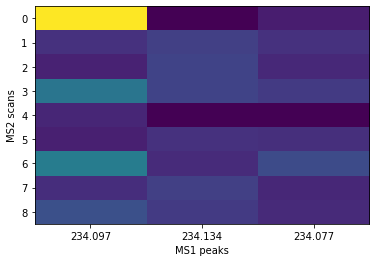

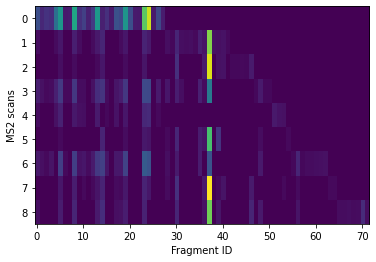

In [97]:
from ms2_matching import create_deconvolution_matrices
A,B,frags_idx,box_idx = create_deconvolution_matrices(relevant_scans,interesting_boxes)
plt.figure()
plt.imshow(A,aspect='auto')
plt.xlabel('MS1 peaks')
plt.xticks([0,1,2],["{:.3f}".format(b.mz) for b in interesting_boxes])
plt.ylabel('MS2 scans')
plt.figure()
plt.imshow(B,aspect='auto')
plt.xlabel('Fragment ID')
plt.ylabel('MS2 scans')

In [98]:
from ms2_matching import deconvolve
out_mat = deconvolve(A,B,frags_idx)

Looks nasty, scared
12 pairs of observations (of 36.0) have correlation > 0.75
[[769174.65469969      0.          62870.09272934]
 [110481.93286148 145219.9813838  109309.45465997]
 [ 73865.19948021 156025.67641755  88446.46792838]
 [299679.50261488 155024.87434345 129557.80983757]
 [ 83606.49615216      0.              0.        ]
 [ 67440.36472153 109474.32053625 102855.82346119]
 [324320.52580718  93211.03542547 176012.00601892]
 [102003.43060365 145394.58515265  86162.85303591]
 [187217.71903913 132012.49922207  92382.53619416]]


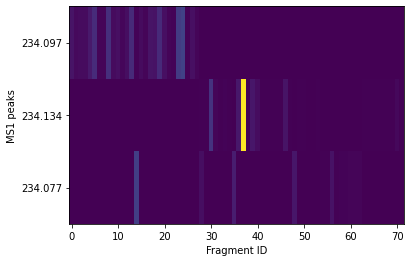

In [103]:
plt.imshow(out_mat,aspect='auto')
plt.xlabel('Fragment ID')
plt.ylabel('MS1 peaks')
h = plt.yticks([0,1,2],["{:.3f}".format(b.mz) for b in interesting_boxes])

Here are the deconvolved intensities

In [157]:
heads = ["{:3d}".format(-1)]+["{:8s}".format("")]+["{:8.3f}".format(b.mz) for b in interesting_boxes]
print("\t".join(heads))
for f,pos in frags_idx.items():
    line = ["{:3d}".format(pos)]+["{:8.2f}".format(f)]
    for i in range(3):
        line.append("{:8.3f}".format(out_mat[i,pos]))
    print("\t".join(line))

 -1	        	 234.097	 234.134	 234.077
  0	   74.06	   0.038	   0.000	   0.000
  1	   85.03	   0.017	   0.000	   0.000
  2	   86.06	   0.020	   0.000	   0.000
  3	   87.03	   0.020	   0.000	   0.000
  4	   90.05	   0.049	   0.000	   0.000
  5	   97.03	   0.086	   0.000	   0.000
  6	   98.06	   0.011	   0.000	   0.000
  7	   99.04	   0.010	   0.000	   0.000
  8	  102.05	   0.093	   0.000	   0.000
  9	  112.04	   0.022	   0.000	   0.000
 10	  122.06	   0.028	   0.000	   0.000
 11	  126.05	   0.012	   0.000	   0.000
 12	  127.04	   0.027	   0.000	   0.000
 13	  143.06	   0.084	   0.000	   0.000
 14	  144.99	   0.006	   0.001	   0.131
 15	  152.07	   0.021	   0.000	   0.000
 16	  158.74	   0.009	   0.000	   0.000
 17	  161.07	   0.038	   0.000	   0.000
 18	  168.07	   0.035	   0.000	   0.000
 19	  170.08	   0.085	   0.000	   0.000
 20	  173.45	   0.028	   0.000	   0.000
 21	  181.54	   0.008	   0.000	   0.000
 22	  187.76	   0.008	   0.000	   0.000
 23	  188.09	   0.122	   0.000	   0.000


In [131]:
for box,pos in box_idx.items():
    print(box.mz,pos)

234.09718322753906 0
234.13352966308594 1
234.0769805908203 2


## Correlation plots

Show how the MS1 intensity correlates with the MS2 intensity of particular fragments

In [189]:
reverse_frags_idx = {v:k for k,v in frags_idx.items()}

In [190]:
def make_correlation_plot(frag_pos):
    plt.figure(figsize=(15,4))
    frag_mz = reverse_frags_idx[frag_pos]
    for box,pos in box_idx.items():
        plt.subplot(1,3,pos+1)
        plt.plot(A[:,pos],B[:,frag_pos],'ro')
        plt.title("{:.3f} -> {:.2f}".format(box.mz,out_mat[pos,frag_pos]))
        plt.xlabel('MS1 intensity')
        plt.ylabel('{:.2f} intensity'.format(frag_mz))

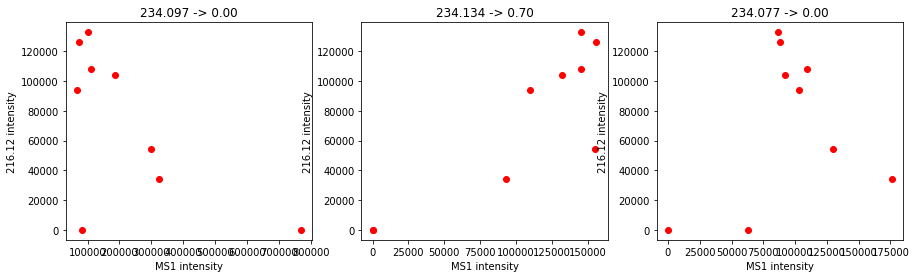

In [191]:
make_correlation_plot(37)

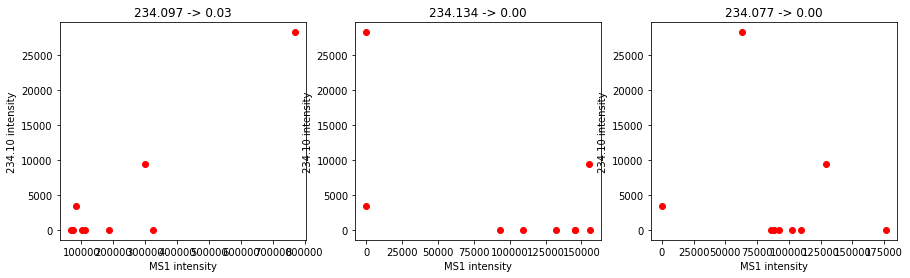

In [192]:
make_correlation_plot(26)

Some fragments end up in more than one spectrum.

- For example, m/z = 144.99 (plotted below).
- It correlates with both 234.097 and 234.077, although best with 234.077

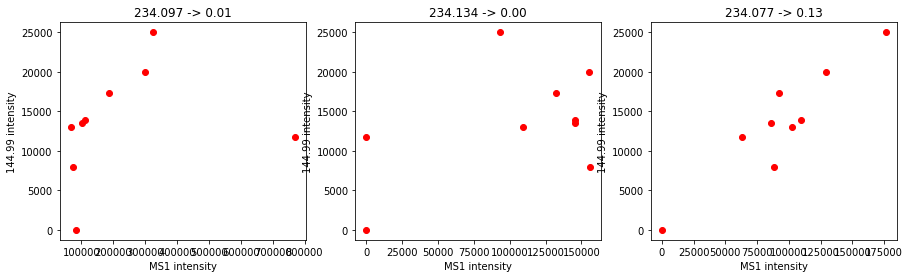

In [226]:
make_correlation_plot(14)

Make spectrum objects for the new spectra

In [227]:
new_spectra = {}
for box,bpos in box_idx.items():
    peaks = []
    for f,fpos in frags_idx.items():
        intensity = out_mat[bpos,fpos]
        if intensity > 0:
            peaks.append((f,intensity))
        peaks.sort(key = lambda x: x[0]) # Don't forget this...v important
    new_spectra[box] = SpectralRecord(box.mz,peaks,None,None,None)

Compute their similarity with one another -- this could be a diagnostic..I think it should be low

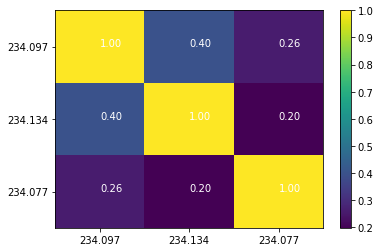

In [232]:
new_sim_mat = np.zeros((len(box_idx),len(box_idx)))
for box,bpos in box_idx.items():
    for box2,bpos2 in box_idx.items():
        a,b = cosine_similarity(new_spectra[box],new_spectra[box2],0.2,0)
        new_sim_mat[bpos,bpos2] = a
labels = ["" for box in box_idx]
for box,pos in box_idx.items():
    labels[pos] = "{:.3f}".format(box.mz)
plt.imshow(new_sim_mat,aspect='auto')
plt.colorbar()
plt.xticks(range(len(box_idx)),labels)
plt.yticks(range(len(box_idx)),labels)
ax = plt.gca()
for i in range(len(box_idx)):
    for j in range(len(box_idx)):
        ax.text(i,j,"{:.2f}".format(new_sim_mat[i,j]),color=[1,1,1])

In [235]:
def plot_spectra(spectrum,normalised_peaks = True,**kwargs):
    plt.figure(**kwargs)
    if normalised_peaks:
        peaks = spectrum.normalised_peaks
    else:
        peaks = spectrum.peaks
    for mz,intensity in peaks:
        plt.plot([mz,mz],[0,intensity],'k')

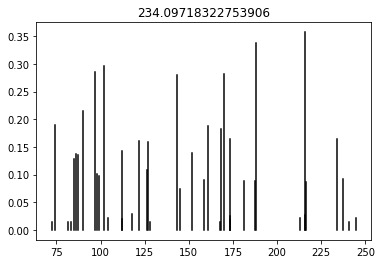

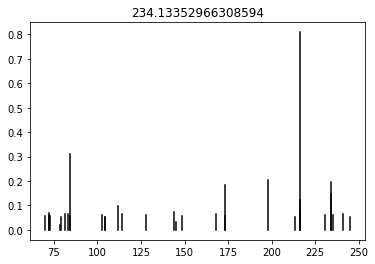

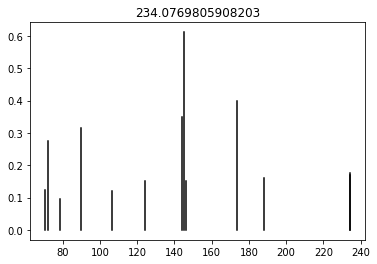

In [237]:
for box,spectrum in new_spectra.items():
    plot_spectra(spectrum)
    plt.title(box.mz)